This notebook shows an example of fitting Prophet models with trends that vary by a specified covariate.

In [10]:
library(SpatioTemporal)
library(tidyr)
library(dplyr)
library(prophet)
library(foreach)
library(ggplot2)
library(Metrics)
library(gridExtra)
library(lubridate)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [11]:
data("mesa.data.raw")

In [12]:
obs <- as.data.frame(mesa.data.raw$obs)
obs[['date']] <- rownames(mesa.data.raw$obs)
obs <- obs %>% 
        gather(key = ID, value = conc, -date) %>%
        filter(!is.na(conc)) %>%
        merge(., mesa.data.raw$X[, c('ID', 'type', 
                                     'log10.m.to.a1', 
                                     'log10.m.to.a2', 
                                     'log10.m.to.a3', 
                                     'log10.m.to.road',
                                     'km.to.coast')]) %>%
        mutate(ds = lubridate::date(date), y = conc) %>%
        .[, rev(names(.))]


In [13]:
# Select a few sites
ids_to_predict <- c('LC003', '60371103', '60595001')

# Regressors to try
regs_to_try <- c('log10.m.to.a1', 'log10.m.to.a2', 'log10.m.to.a3', 'log10.m.to.road', 'km.to.coast')

Fit models using the standard approach

In [14]:
m1 <- prophet(yearly.seasonality = TRUE, 
              weekly.seasonality = TRUE, 
              daily.seasonality = FALSE, 
              uncertainty_samples = 0,
              mcmc.samples = 0)
for (reg in regs_to_try) {
  m1 <- add_regressor(m1, reg)
}
m1 <- fit.prophet(m1, obs)

preds1 <- foreach(id = ids_to_predict, .combine = rbind.data.frame) %do% {
  pred_df <- obs %>% filter(ID == id)
  pred_out <- predict(m1, pred_df)
  pred_out$ID <- id
  pred_out$y <- pred_df[['y']][order(pred_df[['ds']])]
  return(pred_out)
}

Initial log joint probability = -44.4886
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Fit model with seasonal trends that vary by the specified covariates.

In [15]:
m2 <- prophet(yearly.seasonality = TRUE, 
              weekly.seasonality = TRUE, 
              daily.seasonality = FALSE, 
              uncertainty_samples = 0,
              mcmc.samples = 0)

for (reg in regs_to_try) {
  m2 <- add_regressor(m2, reg, modify_seasonality = TRUE)
}
m2 <- fit.prophet(m2, obs)

preds2 <- foreach(id = ids_to_predict, .combine = rbind.data.frame) %do% {
  pred_df <- obs %>% filter(ID == id)
  pred_out <- predict(m2, pred_df)
  pred_out$ID <- id
  pred_out$y <- pred_df[['y']][order(pred_df[['ds']])]
  return(pred_out)
}

Initial log joint probability = -44.4886
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Plot fits from different models

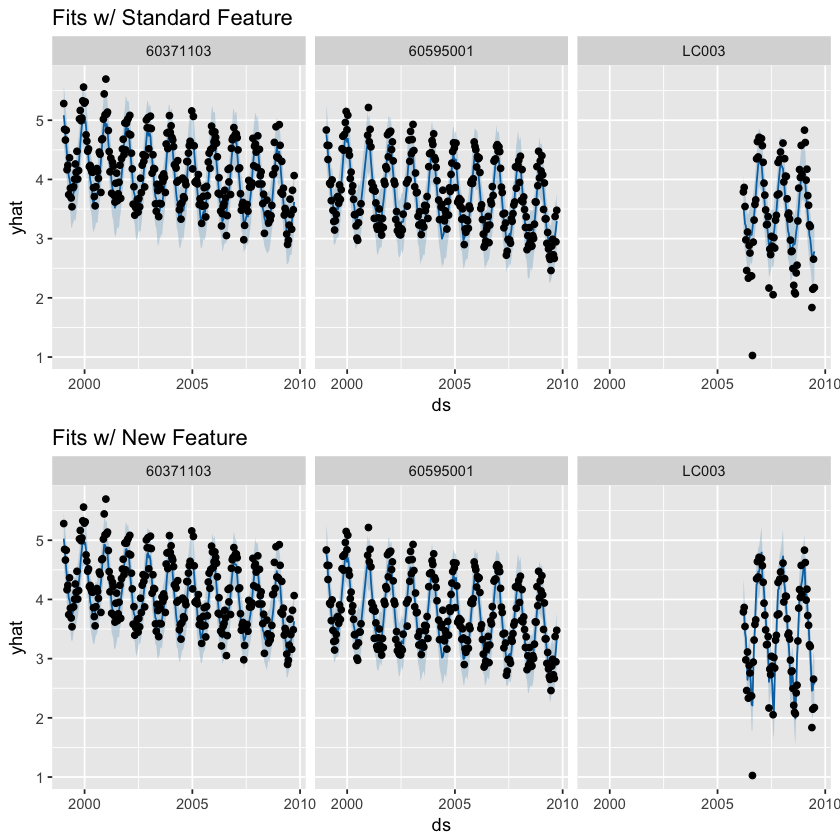

In [16]:
p1_fit <- prophet::plot_forecast_component(preds1, 'yhat') + 
  geom_point(data = preds1, aes(x = ds, y = y)) +
  facet_grid(~ ID) + ggtitle('Fits w/ Standard Feature') 
p2_fit <- prophet::plot_forecast_component(preds2, 'yhat') + 
  geom_point(data = preds2, aes(x = ds, y = y)) + 
  facet_grid(~ ID) + ggtitle('Fits w/ New Feature')
grid.arrange(p1_fit, p2_fit)

Plot trends from different models

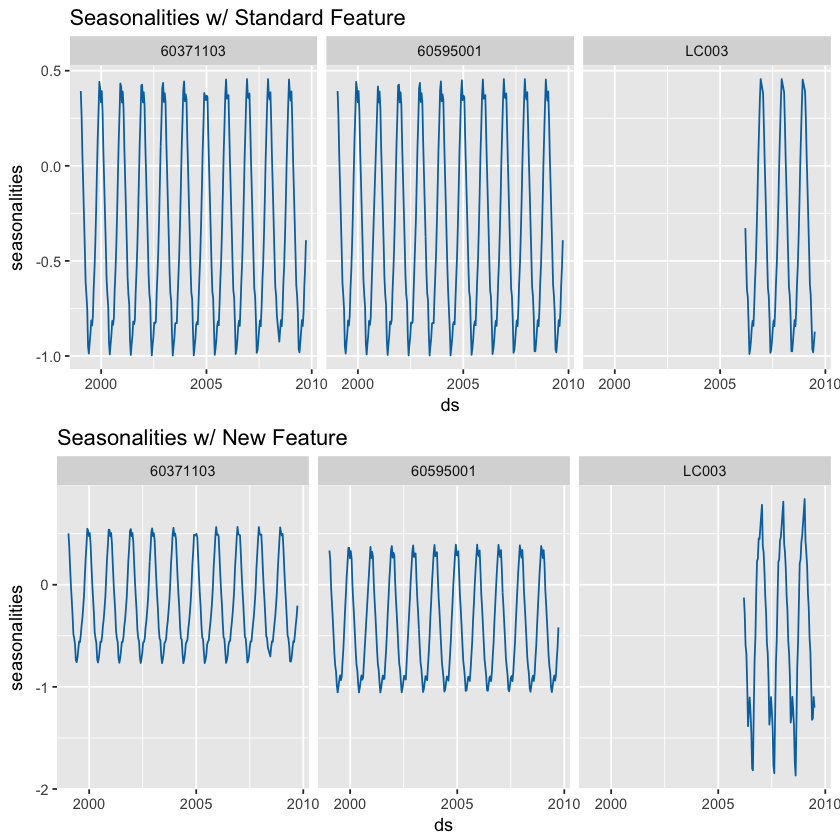

In [17]:
p1_seasonal <- prophet::plot_forecast_component(preds1, 'seasonalities') + 
  facet_grid(~ ID) + ggtitle('Seasonalities w/ Standard Feature') 
p2_seasonal <- prophet::plot_forecast_component(preds2, 'seasonalities') + 
  facet_grid(~ ID) + ggtitle('Seasonalities w/ New Feature') 
grid.arrange(p1_seasonal, p2_seasonal)

What is the in-sample RMSE?

In [18]:
rmse(preds1$y, preds1$yhat)
rmse(preds2$y, preds2$yhat)

[1] 0.2852711

[1] 0.249022